In [1]:
%matplotlib widget
import os
import numpy as np
import hyperspy.api as hs
import atomap.api as am
import atomap.initial_position_finding as ipf
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import scipy
#import scipy.ndimage


In [2]:
#Atomap-based algorithm is the following:
# - load STEM image 's'
# - create a copy with gaussian smooth applied 's1'
# - find atomic columnd by 's1' with manual tune of parameters
# - refine positions by center of mass and 2D gaussian using the original frame 's'
# - retrieve intensities
# - export the list of coordinates - with intensities and ellipticity - as a nunmpy array

In [3]:
#Here we are loading STEM frame as TIFF file
#or any other format supported by HyperSpy 


folder = '/home/vasily/test_fit_atomap/'
fname = 'test_frame'

s = hs.load(folder+fname+'.tif')
#s = hs.load(folder+fname) #for dm3s


metadata = {}
metadata['fname'] = fname
#'''

#if one needs the scalebar, feel free to uncomment and add values
'''
imsize = (64,64)#nm
metadata['imsize'] = imsize
imsize_px = (s.axes_manager[0].size,s.axes_manager[1].size)
#xy directions not checked! has to be verified
d0,d1 = imsize[0]/imsize_px[0],imsize[1]/imsize_px[1]
print(d0,d1)
#Flaw!!! atomap apparently does not support non-sqare pixels!

s.axes_manager[0].scale = d0
s.axes_manager[1].scale = d1
s.axes_manager[0].units = 'nm'
s.axes_manager[1].units = 'nm'
'''

"\nimsize = (64,64)#nm\nmetadata['imsize'] = imsize\nimsize_px = (s.axes_manager[0].size,s.axes_manager[1].size)\n#xy directions not checked! has to be verified\nd0,d1 = imsize[0]/imsize_px[0],imsize[1]/imsize_px[1]\nprint(d0,d1)\n#Flaw!!! atomap apparently does not support non-sqare pixels!\n\ns.axes_manager[0].scale = d0\ns.axes_manager[1].scale = d1\ns.axes_manager[0].units = 'nm'\ns.axes_manager[1].units = 'nm'\n"

In [4]:
#For combined BF/DF datasets
#s = s[1]

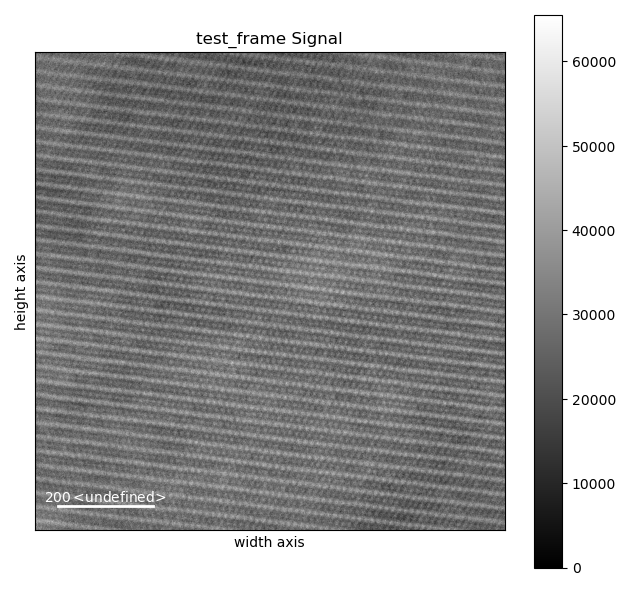

In [5]:
s.plot()

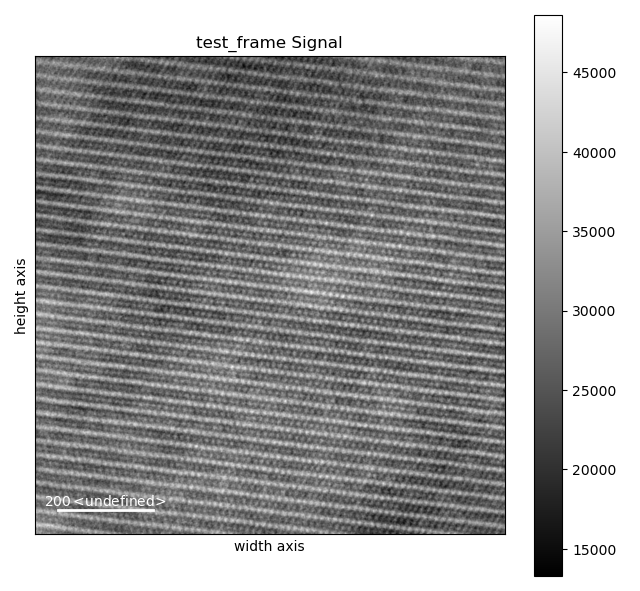

In [6]:
#Gaussian smooth

s1 = s.copy()
s1.map(scipy.ndimage.gaussian_filter, sigma=1)
s1.plot()
#plt.close()

In [7]:
#Preview

substract_backgound = True
threshold_rel = 0.25
pca = True

#Parameters of feature search should be the same in a preview (here)
#and in the actual run (next cell)

s_pks = am.get_feature_separation(s1, separation_range=(2, 20),subtract_background=substract_backgound,
                                  threshold_rel=threshold_rel, pca=pca, show_progressbar=False)
s_pks.plot()

In [8]:
#Here we are manually picking the optimal value

sep = 5
atom_positions = am.get_atom_positions(s1,subtract_background=substract_backgound,
                                  threshold_rel=threshold_rel, pca=pca, separation=sep)
metadata['separation_1'] = sep

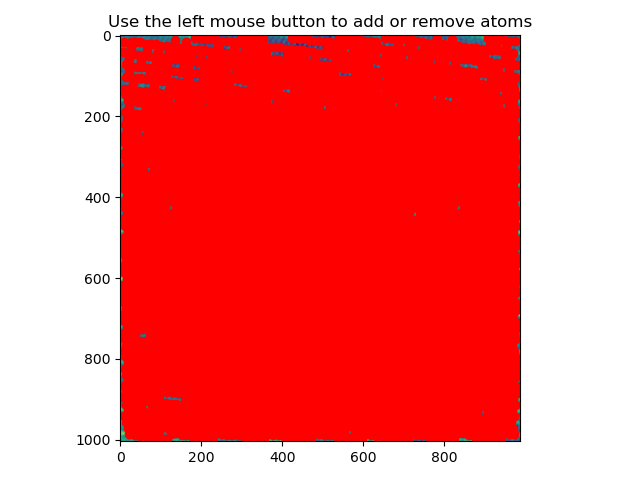

In [9]:
#Opportunity for manual handling
atom_positions2 = ipf.add_atoms_with_gui(s1,atom_positions=atom_positions)
#atom_positions2 = ipf.add_atoms_with_gui(s,atom_positions=atom_positions2) #if manual rerun is needed

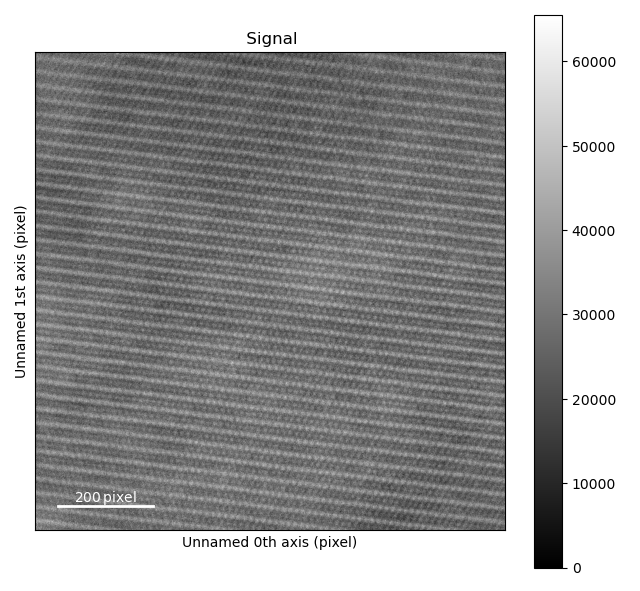

In [10]:
#Preview of the outcome
plt.close('all')
sublattice = am.Sublattice(atom_positions2, image=s)
sublattice.plot()

In [11]:
#Refine
sublattice.find_nearest_neighbors()
sublattice.refine_atom_positions_using_center_of_mass(s.data)

#Could be reasonable to tune the value of the % to the nearest neighbour threshold
#ptonn = 0.2
sublattice.refine_atom_positions_using_2d_gaussian(s.data)#percent_to_nn=ptonn
#metadata['percent_to_nn']=ptonn
#sublattice.refine_atom_positions_using_center_of_mass()

Center of mass:   0%|          | 0/4853 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/4853 [00:00<?, ?it/s]

In [12]:
sublattice.get_position_history().plot()

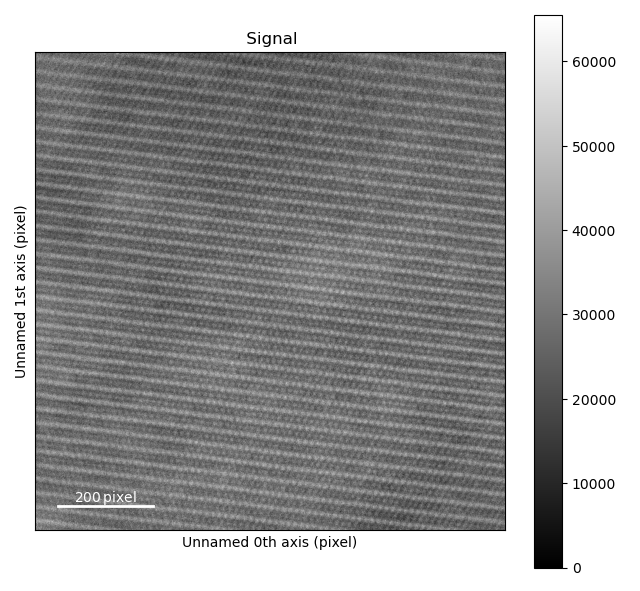

In [13]:
#Preview of the output dataset
plt.close('all')
sublattice.plot()


In [14]:
#Intensities are calculated here
i_points, i_record, p_record = sublattice.integrate_column_intensity()

Calculating Voronoi:   0%|          | 0/991952 [00:00<?, ?it/s]

Integrating:   0%|          | 0/4853 [00:00<?, ?it/s]

Building intensity map:   0%|          | 0/991952 [00:00<?, ?it/s]

In [15]:
#Export

x = sublattice.x_position
y = sublattice.y_position
size = sublattice.pixel_size
ellipticity = np.asarray(sublattice.ellipticity) - 1
rot = -np.asarray(sublattice.rotation_ellipticity)
np.save(folder+fname.split('.')[0],np.array([x,y,ellipticity,rot,i_points]))
observed_xy = [ (i*size,j*size) for i,j in zip(x,y)]

In [16]:
#Ellipticity check, if needed

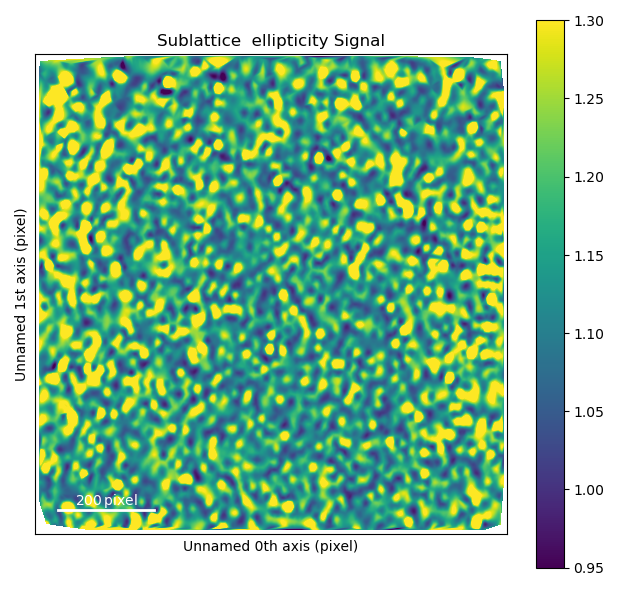

In [17]:
sublattice.plot_ellipticity_map(cmap='viridis', vmin=0.95, vmax=1.3)

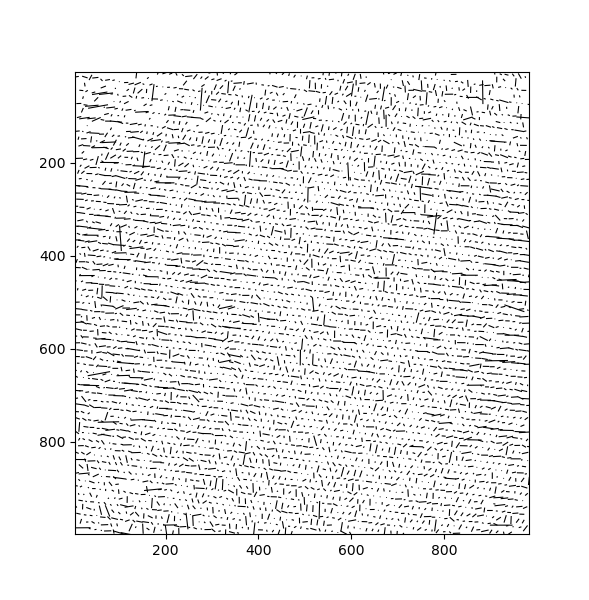

In [18]:
sublattice.plot_ellipticity_vectors()